In [15]:
import os
import pandas as pd
os.getcwd()

path = "c:\\Users\\esthelle.kuissu\\OneDrive - Exiom Partners\\Documents\\Code_rapport_stage\\Bases sinistres"

dataf = pd.read_csv(path + "\\bdd_sinistres_concat.csv", sep=";", encoding="latin1")


C:\Users\esthelle.kuissu\AppData\Local\Temp\ipykernel_21904\2131796732.py:7: DtypeWarning: Columns (24,40,83,105) have mixed types. Specify dtype option on import or set low_memory=False.
  dataf = pd.read_csv(path + "\\bdd_sinistres_concat.csv", sep=";", encoding="latin1")


In [16]:
# 1) Nombre de valeurs manquantes
print("Nombre de NA par colonne :")
print(dataf[['date_nais_f', 'date_permis_f']].isna().sum())

# 2) Aperçu des lignes où au moins l'une des deux dates est manquante
missing_rows = dataf[
    dataf['date_nais_f'].isna() | dataf['date_permis_f'].isna()
]

print(f"\n{missing_rows.shape[0]} lignes concernées. Aperçu :")
print(missing_rows[['date_nais_f', 'date_permis_f']].head())


Nombre de NA par colonne :
date_nais_f      0
date_permis_f    0
dtype: int64

0 lignes concernées. Aperçu :
Empty DataFrame
Columns: [date_nais_f, date_permis_f]
Index: []


## Création de l'identifiant unique

In [17]:
print(dataf.columns.tolist())

# Regrouper par date de naissance et date de première souscription
groupes = dataf.groupby(['date_nais_f', 'date_permis_f']).size().reset_index(name='nb_personnes')

# Afficher les combinaisons où plusieurs personnes partagent les mêmes dates
groupes_filtrés = groupes[groupes['nb_personnes'] > 1]

print(groupes_filtrés)

['cle_sin', 'date_evt', 'date_evt_decla', 'clos', 'sans_suite', 'quart_resp', 'date_premsous', 'date_dernrempl', 'formule_ratt', 'cond_indet', 'date_nais', 'age', 'date_permis', 'anc_permis', 'sexe', 'profess', 'sitfam', 'orig_attest', 'aac', 'date_sortie_veh', 'age_veh', 'usage2', 'franch', 'rachat_francBG', 'garag', 'marq', 'modele2', 'generation', 'modele_desc', 'caros', 'segment', 'energ', 'num_sra', 'cylin', 'pdyne', 'pkw', 'pfisc', 'vites', 'pvid', 'poidspuiss', 'sport', 'frein', 'cdval', 'trans', 'alim', 'suspe', 'boite', 'val', 'couple', 'airbag', 'crash', 'co2min', 'elt_secu', 'vu', 'pickup', 'luxe', 'prestige', 'soumis_crm', 'crm', 'boncond', 'nab50', 'bureau_ratt', 'fract_paiem_soc', 'formule_gar', 'petit_rouleur', 'systeme', 'exercice', 'GARANTIE_HOST', 'MT_FRANCHISE', 'MT_CHARGE_BRUTE', 'MT_CHARGE_NETTE', 'MT_REGLEMENT_SIN', 'MT_REGLEMENT_COM', 'MT_ABANDON_RECOURS', 'MT_FRAIS_HONO', 'MT_PROVISIONS', 'MT_RECOURS_TOTAL', 'MT_ESTIMATION_RECOURS_RESTANTS', 'MT_AVANCE_RECOURS',

In [18]:
#Étape 2 : filtrer les lignes concernées dans le DataFrame d'origine
df_doublons = dataf.merge(groupes[['date_nais_f', 'date_permis_f']], on=['date_nais_f', 'date_permis_f'])

# Étape 3 : afficher les colonnes souhaitées
colonnes = ['date_nais_f', 'date_permis_f', 'sexe', 'exercice', 'date_premsous']
df_resultat = df_doublons[colonnes]

# Affichage
print(df_resultat)


        date_nais_f date_permis_f sexe  exercice date_premsous
0        13/01/1934    04/05/1960    F      2019    29/06/1987
1        09/11/2000    09/11/2018    M      2019    10/11/2018
2        05/10/1951    06/10/1969    M      2019    13/07/2016
3        27/05/1978    05/09/1997    M      2019    25/10/2015
4        13/05/1971    05/02/1990    F      2019    10/06/2015
...             ...           ...  ...       ...           ...
1001840  24/11/1987    09/08/2007    M      2024    01/01/2023
1001841  18/01/1949    27/01/1969    F      2024    09/04/1999
1001842  03/03/1971    25/08/2004    M      2024    13/06/2016
1001843  14/01/1962    26/09/2007    M      2024    25/10/2022
1001844  22/04/2003    15/03/2022    F      2024    15/04/2024

[1001845 rows x 5 columns]


In [19]:
import pandas as pd
import hashlib

# Étape 1 : extraire les dates brutes s’il y a du texte autour
# Format visé : "28/06/1976" ou similaire
dataf['date_nais_f'] = dataf['date_nais'].astype(str).str.extract(r'(\d{1,2}/\d{1,2}/\d{2,4})')[0]
dataf['date_permis_f'] = dataf['date_permis'].astype(str).str.extract(r'(\d{1,2}/\d{1,2}/\d{2,4})')[0]

# Étape 2 : conversion en datetime (au format français jour/mois/année)
dataf['date_nais_f'] = pd.to_datetime(dataf['date_nais_f'], format='%d/%m/%Y', errors='coerce')
dataf['date_permis_f'] = pd.to_datetime(dataf['date_permis_f'], format='%d/%m/%Y', errors='coerce')

# Étape 3 : vérifier que la conversion a bien fonctionné
print(dataf['date_nais_f'].isna().sum(), "dates de naissance mal converties")
print(dataf['date_permis_f'].isna().sum(), "dates de permis mal converties")

# Étape 4 : créer une chaîne concaténée propre
dataf['identifiant_concat'] = (
    dataf['date_nais_f'].astype(str) + '_' +
    dataf['date_permis_f'].astype(str) + '_' +
    dataf['sexe'].astype(str)
)

# Étape 5 : créer un identifiant unique (version hachée md5)
dataf['identifiant_unique'] = dataf['identifiant_concat'].apply(
    lambda x: hashlib.md5(x.encode()).hexdigest()
)

# Étape 6 (optionnel) : vérifier l’unicité
n_total = len(dataf)
n_uniques = dataf['identifiant_unique'].nunique()
print(f"{n_uniques} identifiants uniques sur {n_total} lignes")

0 dates de naissance mal converties
0 dates de permis mal converties
801820 identifiants uniques sur 1001845 lignes


In [20]:
# Compter les occurrences de chaque triplet et trier par ordre décroissant 
compte_triplets = (
    dataf
    .groupby(['date_nais_f', 'date_permis_f', 'sexe', 'exercice'])
    .size()
    .reset_index(name='nb_apparitions')
    .sort_values(by='nb_apparitions', ascending=False)
)

print(compte_triplets)

       date_nais_f date_permis_f sexe  exercice  nb_apparitions
19524   1935-04-02    1971-07-08    F      2022               7
558651  1969-06-15    2005-07-24    F      2020               7
488490  1965-05-21    1987-03-10    F      2024               7
40974   1938-06-24    1956-07-19    M      2021               6
141391  1947-03-02    1966-09-02    F      2023               6
...            ...           ...  ...       ...             ...
950987  2006-11-23    2024-01-01    M      2024               1
950988  2006-11-24    2024-07-04    M      2024               1
950989  2006-11-29    2024-06-03    M      2024               1
950990  2006-12-04    2024-07-03    M      2024               1
950991  2006-12-07    2024-04-12    M      2024               1

[951008 rows x 5 columns]


In [21]:
# Statistiques descriptives par exercice
stats_par_exercice = (
    compte_triplets
    .groupby('exercice')['nb_apparitions']
    .agg(['count', 'mean', 'median', 'min', 'max', 'std', 'sum', 'quantile'])
    .sort_index()
)

print(stats_par_exercice)

           count      mean  median  min  max       std     sum  quantile
exercice                                                                
2019      161032  1.056225     1.0    1    5  0.246806  170086       1.0
2020      137734  1.048405     1.0    1    7  0.230224  144401       1.0
2021      156393  1.053890     1.0    1    6  0.243198  164821       1.0
2022      160121  1.054090     1.0    1    7  0.241965  168782       1.0
2023      163325  1.052288     1.0    1    6  0.236634  171865       1.0
2024      172403  1.055028     1.0    1    7  0.245715  181890       1.0


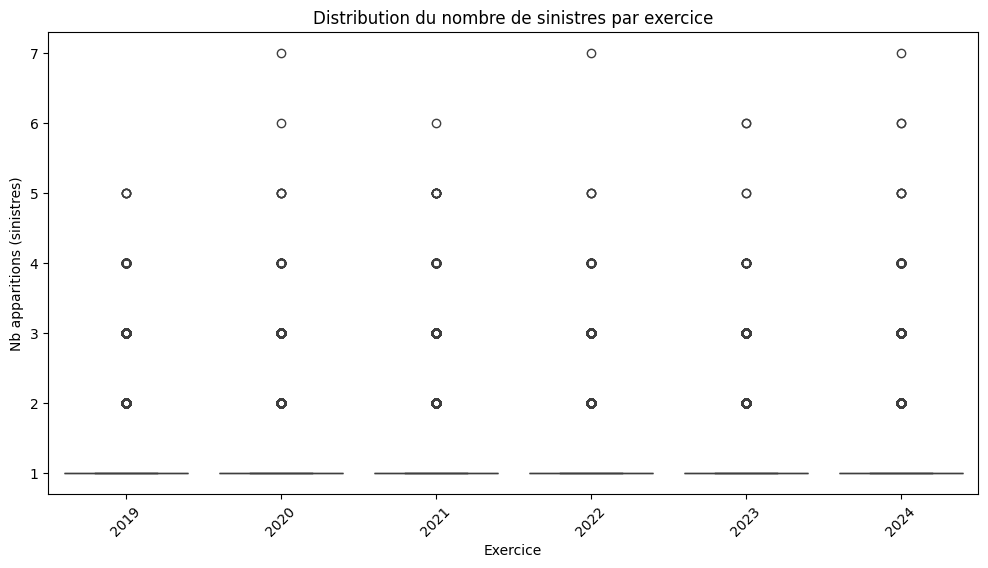

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=compte_triplets, x='exercice', y='nb_apparitions')
plt.title('Distribution du nombre de sinistres par exercice')
plt.ylabel('Nb apparitions (sinistres)')
plt.xlabel('Exercice')
plt.xticks(rotation=45)
plt.show()

In [24]:
# Exemple : si CRM est dans data_modifiee
df_corr = compte_triplets.merge(
    dataf[['date_nais_f', 'date_permis_f', 'sexe', 'exercice', 'crm']],
    on=['date_nais_f', 'date_permis_f', 'sexe', 'exercice'],
    how='left'
)

In [25]:
correlation = df_corr['crm'].corr(df_corr['nb_apparitions'])
print(f"Corrélation entre CRM et nombre de sinistres : {correlation:.4f}")

Corrélation entre CRM et nombre de sinistres : 0.0358


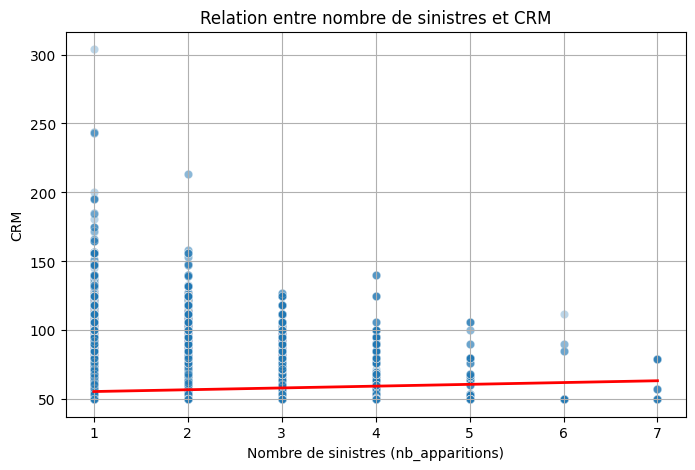

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_corr, x='nb_apparitions', y='crm', alpha=0.3)
sns.regplot(data=df_corr, x='nb_apparitions', y='crm', scatter=False, color='red', line_kws={"lw":2})
plt.title("Relation entre nombre de sinistres et CRM")
plt.xlabel("Nombre de sinistres (nb_apparitions)")
plt.ylabel("CRM")
plt.grid(True)
plt.show()

SINISTRES Par année

In [29]:
# Créer les variables indicatrices pour les exercices 2019 à 2024
for annee in range(2019, 2025):
    dataf[f'ex_{str(annee)[-2:]}'] = (dataf['exercice'] == annee).astype(int)


In [30]:
# Somme des indicateurs par identifiant_unique
somme_ex = (
    dataf
    .groupby('identifiant_unique')[['ex_19', 'ex_20', 'ex_21', 'ex_22', 'ex_23', 'ex_24']]
    .sum()
    .reset_index()
)


In [31]:
somme_ex.head()

,identifiant_unique,ex_19,ex_20,ex_21,ex_22,ex_23,ex_24
0,000007ea08e97eae83ed87e136655e13,0,0,1,0,0,0
1,00000dc777e5ceb94f7ec3cfc666c2ef,0,1,0,0,0,0
2,000018a7446a3feb14cdb730f49f02c3,2,0,0,0,0,0
3,000042c4928a3415f29a849aa4f34ef7,0,0,0,0,1,0
4,00004befd746bbfef0acb28f091e2ced,0,1,0,0,0,0


In [32]:
presence_par_individu = (
    dataf
    .groupby('identifiant_unique')[['ex_19', 'ex_20', 'ex_21', 'ex_22', 'ex_23', 'ex_24']]
    .max()
    .reset_index()
)


In [33]:
# Ajout d'une colonne qui compte le nombre total d'années de présence
somme_ex['total_exercices'] = (
    somme_ex[['ex_19', 'ex_20', 'ex_21', 'ex_22', 'ex_23', 'ex_24']].sum(axis=1)
)

# Tri décroissant par total_exercices
somme_ex = somme_ex.sort_values(by='total_exercices', ascending=False)

# Affichage
print(somme_ex.head())


                      identifiant_unique  ex_19  ex_20  ex_21  ex_22  ex_23  \
3226    0105144b8f7ae231d6d40624de3a3f7a      3      2      3      1      2   
340069  6cad5b27ae40c2db8d2a378b7075fd55      1      2      3      2      2   
574511  b77abea35f0b1ee869d492368bd3e8a4      2      0      3      3      2   
783378  fa1be6a732219fb7e73126f5516e8302      0      0      0      1      6   
729681  e90c4179959de55801692aac890c9a64      0      0      3      3      2   

        ex_24  total_exercices  
3226        1               12  
340069      2               12  
574511      0               10  
783378      2                9  
729681      1                9  


In [34]:
import pandas as pd

# --- 1. S’assurer que la date de première souscription est bien au format datetime
dataf['date_premsous'] = pd.to_datetime(
    dataf['date_premsous'],              # ou le nom réel de la colonne
    errors='coerce',                             # lignes mal formatées ➜ NaT
    dayfirst=True                                # si ton csv est JJ/MM/AAAA
)

# --- 2. Créer l’année de première souscription
dataf['an_premsous'] = dataf['date_premsous'].dt.year

# --- 3. Générer les indicateurs binaires pré-souscription 2019-2024
for an in range(2019, 2025):
    dataf[f'pre_{str(an)[-2:]}'] = (dataf['an_premsous'] <= an).astype(int)

# --- 4. (Rappel) : si ce n’est pas déjà fait, ex_19-ex_24 indiquent la présence dans chaque exercice
for an in range(2019, 2025):
    dataf[f'ex_{str(an)[-2:]}'] = (dataf['exercice'] == an).astype(int)

# --- 5. Agréger : une ligne par identifiant_unique, max() ➜ 0/1
pre_cols = [f'pre_{yy}' for yy in ['19', '20', '21', '22', '23', '24']]
ex_cols  = [f'ex_{yy}'  for yy in ['19', '20', '21', '22', '23', '24']]

df_indiv = (
    dataf
      .groupby('identifiant_unique')[pre_cols + ex_cols]
      .max()
      .reset_index()
)

# --- 6. Ajouter total_exercice (nb d’années où l’individu apparaît)
df_indiv['total_exercice'] = df_indiv[ex_cols].sum(axis=1)

# --- 7. (Optionnel) ordonner les colonnes pour lecture / export
col_order = ['identifiant_unique'] + pre_cols + ex_cols + ['total_exercice']
df_indiv  = df_indiv[col_order]

# --- 8. Aperçu
print(df_indiv.head())

# --- 9. Sauvegarde éventuelle
# df_indiv.to_csv('individus_pre_ex_total.csv', index=False)


                 identifiant_unique  pre_19  pre_20  pre_21  pre_22  pre_23  \
0  000007ea08e97eae83ed87e136655e13       1       1       1       1       1   
1  00000dc777e5ceb94f7ec3cfc666c2ef       1       1       1       1       1   
2  000018a7446a3feb14cdb730f49f02c3       1       1       1       1       1   
3  000042c4928a3415f29a849aa4f34ef7       1       1       1       1       1   
4  00004befd746bbfef0acb28f091e2ced       1       1       1       1       1   

   pre_24  ex_19  ex_20  ex_21  ex_22  ex_23  ex_24  total_exercice  
0       1      0      0      1      0      0      0               1  
1       1      0      1      0      0      0      0               1  
2       1      1      0      0      0      0      0               1  
3       1      0      0      0      0      1      0               1  
4       1      0      1      0      0      0      0               1  


In [37]:
df_indiv[df_indiv['pre_19'] == 0]


,identifiant_unique,pre_19,pre_20,pre_21,pre_22,pre_23,pre_24,ex_19,ex_20,ex_21,ex_22,ex_23,ex_24,total_exercice
13,0000a23c559bea4e95f69af295708031,0,0,0,1,1,1,0,0,0,1,0,0,1
16,0000bf39b1e5bf23275b884b2b276c11,0,0,1,1,1,1,0,0,0,0,1,0,1
18,0000d1f11eb7504a4e4ad6200ca7abfd,0,0,0,0,0,1,0,0,0,0,0,1,1
22,0000ecd9af8e91fa6d853fa62c219952,0,0,1,1,1,1,0,0,0,0,1,0,1
45,00029678953a0702ec310a328eaa34e6,0,1,1,1,1,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801791,fffde41a9f903676bac665b24c1f9a69,0,0,1,1,1,1,0,0,0,1,0,0,1
801792,fffe1725cbd1ffd48dc78cacf67083af,0,1,1,1,1,1,0,1,0,0,0,0,1
801793,fffe1a569e3b6f99308ddb5b196c7958,0,0,0,1,1,1,0,0,0,0,0,1,1
801814,ffff99c7b291227bcf9d030d01f1603c,0,1,1,1,1,1,0,0,1,0,0,0,1
